In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [102]:
import statsmodels.formula.api as sm
import patsy
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV,learning_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.pipeline import Pipeline

In [103]:
job = pd.read_csv('data_job.csv')
job.shape

(3960, 9)

# EDA and Features Engineering

In [104]:
job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 9 columns):
Unnamed: 0      3960 non-null int64
Job_Id          3960 non-null object
Job_Title       3960 non-null object
Company         3960 non-null object
Date_Posted     3960 non-null object
Salary          3960 non-null object
Seniority       3960 non-null object
Category        3960 non-null object
Requirements    3960 non-null object
dtypes: int64(1), object(8)
memory usage: 278.5+ KB


In [105]:
job.head()

,Unnamed: 0,Job_Id,Job_Title,Company,Date_Posted,Salary,Seniority,Category,Requirements
0,0,[b' JOB-2019-0090219 '],"[b'Data Engineer (5 days, Orchard, $3500-4000)']",[b'MACHSPEED HUMAN RESOURCES PTE. LTD.'],[b'Posted 27 Apr 2019'],"['/ $3,500to$4,000/ $3,500/ to$4,000/ Monthly/...",[b'Executive'],[b'Information Technology'],['RequirementsRequirements Minimum Degree/Dip...
1,1,[b' JOB-2019-0090314 '],[b'Customer Engagement Excellence Learning Man...,[b'BAYER (SOUTH EAST ASIA) PTE LTD'],[b'Posted 27 Apr 2019'],"['/ $10,400to$15,400/ $10,400/ to$15,400/ Mont...",[b'Manager'],[b'Healthcare / Pharmaceutical'],['Requirements A University / Bachelors degree...
2,2,[b' JOB-2019-0090256 '],"[b'Manager, Research']",[b'GROUP ONE HOLDINGS PTE. LTD.'],[b'Posted 27 Apr 2019'],"['/ $5,000to$8,000/ $5,000/ to$8,000/ Monthly/...",[b'Manager'],[b'Others'],['Requirements·\xa0\xa0\xa0\xa0\xa0\xa0\xa0A s...
3,3,[b' JOB-2019-0090319 '],"[b'Head of Research &amp; Evaluation, Asia']",[b'SAVE THE CHILDREN ASIA REGIONAL OFFICE LIMI...,[b'Posted 27 Apr 2019'],"['/ $80,000to$140,000/ $80,000/ to$140,000/ An...",[b'Middle Management'],[b'General Management'],['RequirementsQualifications 10 plus years ex...
4,4,[b' JOB-2019-0090300 '],[b'IT Systems Adminstrator'],[b'ELIXIR TECHNOLOGY PTE LTD'],[b'Posted 27 Apr 2019'],"['/ $2,800to$3,500/ $2,800/ to$3,500/ Monthly/...",[b'Professional'],[b'Information Technology'],"[""Requirements Bachelor's Degree in Computer S..."


In [106]:
job_clean = job.drop_duplicates(subset='Job_Id', keep='first') #remove duplicate based on Job ID

#drop job Id as it is only use to remove duplicates
job_clean = job_clean.drop(columns=['Job_Id','Unnamed: 0'])
job_clean.shape

(3932, 7)

In [107]:
for col in job_clean.columns:
    job_clean[col]=job_clean[col].str.replace("(\[|\]|b'|Requirements|'|amp;|xa0|\\\|\|xe2x80x93)", "")
job_clean.head()

,Job_Title,Company,Date_Posted,Salary,Seniority,Category,Requirements
0,"Data Engineer (5 days, Orchard, $3500-4000)",MACHSPEED HUMAN RESOURCES PTE. LTD.,Posted 27 Apr 2019,"/ $3,500to$4,000/ $3,500/ to$4,000/ Monthly/ C...",Executive,Information Technology,"Minimum Degree/Diploma in Computer Science, ..."
1,Customer Engagement Excellence Learning Manager,BAYER (SOUTH EAST ASIA) PTE LTD,Posted 27 Apr 2019,"/ $10,400to$15,400/ $10,400/ to$15,400/ Monthl...",Manager,Healthcare / Pharmaceutical,A University / Bachelors degree holder in app...
2,"Manager, Research",GROUP ONE HOLDINGS PTE. LTD.,Posted 27 Apr 2019,"/ $5,000to$8,000/ $5,000/ to$8,000/ Monthly/ C...",Manager,Others,"·A smart communicator, a team player with proa..."
3,"Head of Research & Evaluation, Asia",SAVE THE CHILDREN ASIA REGIONAL OFFICE LIMITED,Posted 27 Apr 2019,"/ $80,000to$140,000/ $80,000/ to$140,000/ Annu...",Middle Management,General Management,Qualifications 10 plus years expertise and do...
4,IT Systems Adminstrator,ELIXIR TECHNOLOGY PTE LTD,Posted 27 Apr 2019,"/ $2,800to$3,500/ $2,800/ to$3,500/ Monthly/ C...",Professional,Information Technology,""" Bachelors Degree in Computer Science, Comput..."


In [108]:
#check for row with missing job title
job_clean[job_clean['Job_Title'] == '']

,Job_Title,Company,Date_Posted,Salary,Seniority,Category,Requirements
27,,,,,,,


In [109]:
empty = job_clean['Job_Title'] == ''

In [110]:
#remove row without job title
job_clean = job_clean[~empty]

In [111]:
#remove row without salary
no_salary = job_clean['Salary'].str.contains('Salary undisclosed')

In [112]:
job_clean_df = job_clean[~no_salary]

In [113]:
#extract salary into min/max/type category
salary_range = job_clean_df["Salary"].str.split("/", n = 5, expand = True) 

In [114]:
salary_range.head()

,0,1,2,3,4,5
0,,"$3,500to$4,000","$3,500","to$4,000",Monthly,Closing on 27 May 2019
1,,"$10,400to$15,400","$10,400","to$15,400",Monthly,Closing on 12 May 2019
2,,"$5,000to$8,000","$5,000","to$8,000",Monthly,Closing on 27 May 2019
3,,"$80,000to$140,000","$80,000","to$140,000",Annually,Closing on 11 May 2019
4,,"$2,800to$3,500","$2,800","to$3,500",Monthly,Closing on 27 May 2019


In [115]:
salary_range = salary_range.rename({0:'recruiter',1:'range', 2:'min', 3:'max', 4:'type'}, axis='columns')

In [116]:
min_max = salary_range['range'].str.split('to', n=2, expand = True)

In [117]:
min_max = min_max.rename({0:'sal_min', 1:'sal_max'}, axis='columns')

In [118]:
salary_range = pd.concat([salary_range, min_max], axis=1)

In [119]:
salary_range.shape

(3472, 8)

In [120]:
#removed $ and 'to' from salary 
for col in salary_range.columns:
    salary_range[col]=salary_range[col].str.replace('(\$|,|to)', '')
salary_range.head()

,recruiter,range,min,max,type,5,sal_min,sal_max
0,,35004000,3500,4000,Monthly,Closing on 27 May 2019,3500,4000
1,,1040015400,10400,15400,Monthly,Closing on 12 May 2019,10400,15400
2,,50008000,5000,8000,Monthly,Closing on 27 May 2019,5000,8000
3,,80000140000,80000,140000,Annually,Closing on 11 May 2019,80000,140000
4,,28003500,2800,3500,Monthly,Closing on 27 May 2019,2800,3500


In [121]:
#data from job posted by recruiter are shifted to the right
#salary min falls under max and salary max falls under type
salary_range[salary_range['recruiter'].str.contains('Recruiter')].head()

,recruiter,range,min,max,type,5,sal_min,sal_max
53,via Recruiter,,25003200,2500,3200,Monthly/ Closing on 26 May 2019,,None
72,Recruiter,,30005000,3000,5000,Monthly/ Closing on 26 May 2019,,None
96,via Recruiter,,18002600,1800,2600,Monthly/ Closing on 26 May 2019,,None
99,via Recruiter,,63006800,6300,6800,Monthly/ Closing on 26 May 2019,,None
103,via Recruiter,,780012200,7800,12200,Monthly/ Closing on 10 May 2019,,None


In [122]:
#adjust salary min and max for recruiter data
salary_range.loc[salary_range['recruiter'].str.contains('Recruiter'), 'sal_min'] = salary_range['max']
salary_range.loc[salary_range['recruiter'].str.contains('Recruiter'), 'sal_max'] = salary_range['type']

In [123]:
#convert from ojbect to float 
salary_range['sal_min'] = salary_range['sal_min'].astype('float64')
salary_range['sal_max'] = salary_range['sal_max'].astype('float64')

In [124]:
salary_range.describe()

,sal_min,sal_max
count,3472.000000,3472.000000
mean,7215.020449,11079.663882
std,15684.739939,23760.781468
min,1.000000,2.000000
25%,2800.000000,4000.000000
50%,4100.000000,6800.000000
75%,6500.000000,10000.000000
max,280000.000000,405000.000000


In [125]:
abovemean = 3*np.mean(salary_range['sal_min'])

In [126]:
salary_range[((salary_range['recruiter'].str.contains('Recruiter')) & (salary_range['sal_min'] > abovemean))]

,recruiter,range,min,max,type,5,sal_min,sal_max
428,Recruiter,,110000180000,110000,180000,Annually/ Closing on 24 May 2019,110000.0,180000.0
1859,Recruiter,,7000080000,70000,80000,Annually/ Closing on 15 May 2019,70000.0,80000.0


In [127]:
#assume sal_min 3x above mean is Annually type of salary the rest are Monthly type
salary_range.loc[((salary_range['recruiter'].str.contains('Recruiter')) & (salary_range['sal_min'] > abovemean)), 'type'] = ' Annually'
salary_range.loc[((salary_range['recruiter'].str.contains('Recruiter')) & (salary_range['sal_min'] < abovemean)), 'type'] = ' Monthly'

In [128]:
#only keep relevent columns before merge back
salary_range = salary_range.drop(columns=['range','min','max',5])

In [129]:
job_df = pd.concat([job_clean_df, salary_range], axis=1)

In [130]:
#drop original salary columns and job date due to feature not useful for prediction
job_df = job_df.drop(columns=['Date_Posted','Salary','recruiter'])

In [131]:
#assuming typo for sal_max 10 times more than sal_min. To correct value by sal_max divided by 10
job_df.loc[(job_df['sal_max']>10*job_df['sal_min']), 'sal_max'] = job_df['sal_max']/10

In [132]:
#standardize all salary type to Monthly
job_df.loc[job_df['type'].str.contains(' Annually'), 'sal_min'] = round(job_df['sal_min']/12)
job_df.loc[job_df['type'].str.contains(' Annually'), 'sal_max'] = round(job_df['sal_max']/12)
job_df = job_df.drop(columns='type')

In [133]:
col = job_df.columns

In [134]:
#further remove job with same data from all columns
job_df = job_df.drop_duplicates(subset=col, keep='first')

In [135]:
#further filter on job title with specific data job keywords
title_key = ['DATA', 'MACHINE','ANALYST','MACHINE LEARNING','ANALYTICS','DEEP LEARNING','RESEARCH','NLP']
key = '|'.join(title_key)
data_job = job_df['Job_Title'].str.upper().str.contains(key)
job_df = job_df[data_job]

In [136]:
#to drop job with max salary less than 2000, assuming data entry/admin/operator job
mask_low = job_df['sal_max']<=2000
job_df = job_df[~mask_low]

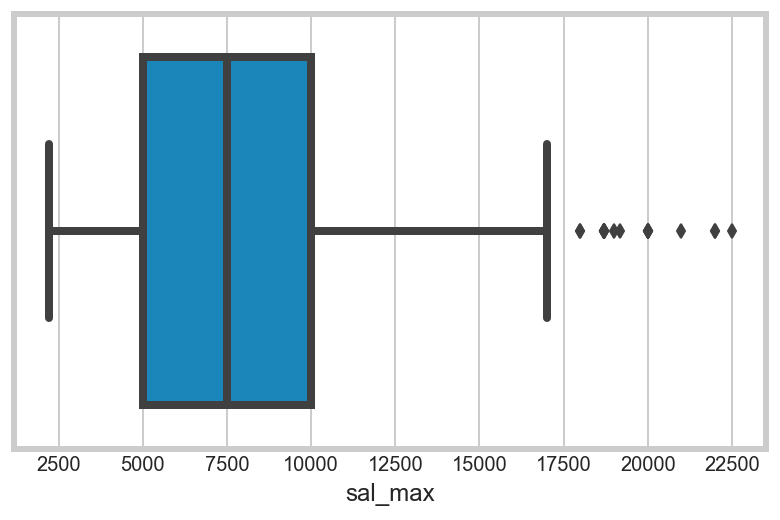

In [137]:
sns.boxplot(job_df['sal_max'])

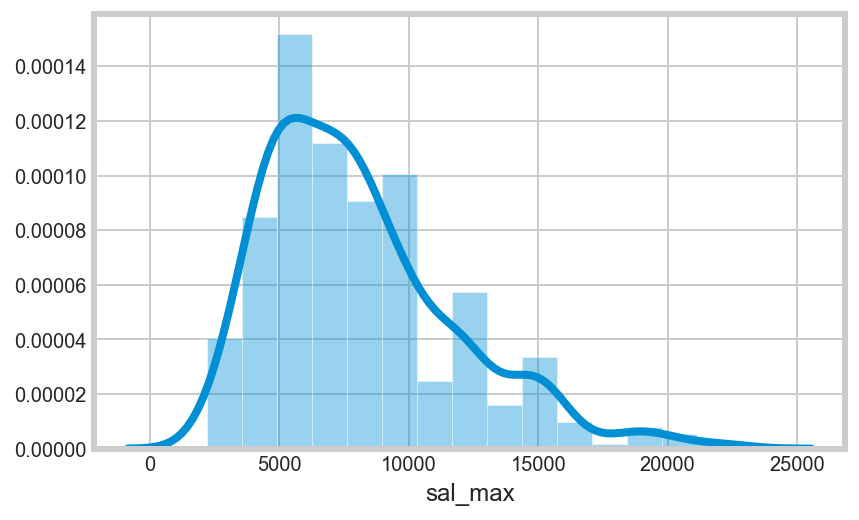

In [138]:
sns.distplot(job_df['sal_max'], bins=15);

In [139]:
#create new feature for average salary
job_df['Avg Salary'] = (job_df['sal_min'] + job_df['sal_max']) / 2

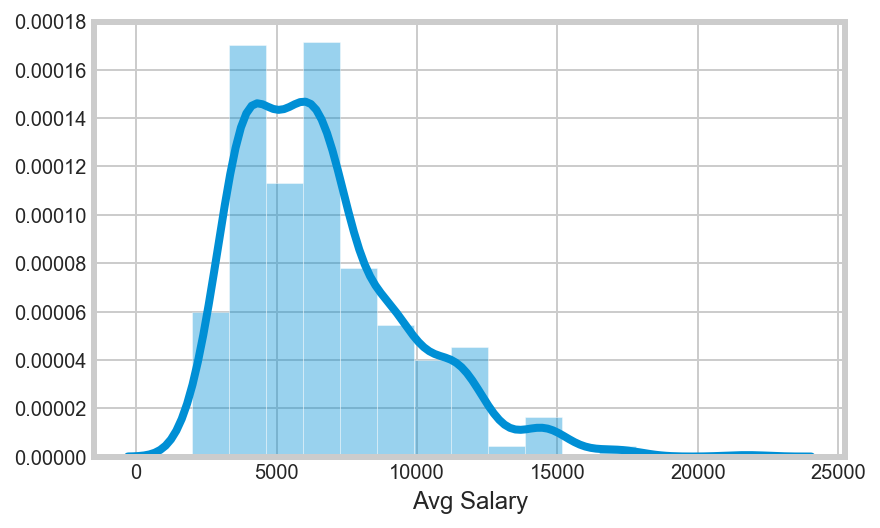

In [140]:
sns.distplot(job_df['Avg Salary'], bins=15);

### create label for high and low salary according to median salary.

In [141]:
job_df["sal_high"] = job_df['Avg Salary'].map(lambda x: 1 if x >= np.median(job_df['Avg Salary']) else 0)
job_df["sal_high"].value_counts()

1    450
0    388
Name: sal_high, dtype: int64

In [142]:
#baseline model at 53% due to salary cut-off at median
baseline = np.mean(job_df["sal_high"])
baseline

0.5369928400954654

In [143]:
job_df = job_df.reset_index(drop=True)

In [144]:
#check seniority with multiple rank
job_df[job_df['Seniority'].str.count(',')>=2].head()

,Job_Title,Company,Seniority,Category,Requirements,sal_min,sal_max,Avg Salary,sal_high
54,Senior / Reporting Analyst,SIVANTOS PTE. LTD.,"Executive, Junior Executive, Senior Executive",Logistics / Supply Chain,The successful candidate will be an individual...,3500.0,5500.0,4500.0,0
63,Data Migration Lead,Company Undisclosed,"Manager, Professional, Senior Executive",Information Technology,"""The Successful Applicant Must have relevant ...",7000.0,10000.0,8500.0,1
70,Data Engineer,FRIARTUCK PTE LTD,"Professional, Executive, Senior Executive","Consulting , Information Technology","""Responsibilities Build the infrastructure an...",6000.0,8000.0,7000.0,1
84,Analyst,AON HEWITT SINGAPORE PTE. LTD.,"Executive, Junior Executive, Senior Executive",Consulting,"Bachelor’s Degree in Business Administration,...",3000.0,4000.0,3500.0,0
139,Project Analyst,INDEPENDENT PROJECT ANALYSIS PRIVATE LIMITED,"Manager, Professional, Senior Executive","Consulting , Professional Services",*Strong quantitative analytical skill/ Underst...,6000.0,10000.0,8000.0,1


In [145]:
job_df['Seniority'] = job_df['Seniority'].str.split(', ')

In [146]:
#job posted with more than 2 seniority classify under multiple,
#second seniority is taken as value for job with 2 seniority 
job_df['Seniority'] = job_df['Seniority'].map(lambda x: x[0] if len(x)>2 else (x[1] if len(x)>1 else x[0]))

In [147]:
job_df['Seniority'].value_counts()

Professional         233
Executive            198
Senior Executive     109
Non-executive         79
Manager               60
Junior Executive      54
Fresh/entry level     41
Middle Management     38
Senior Management     26
Name: Seniority, dtype: int64

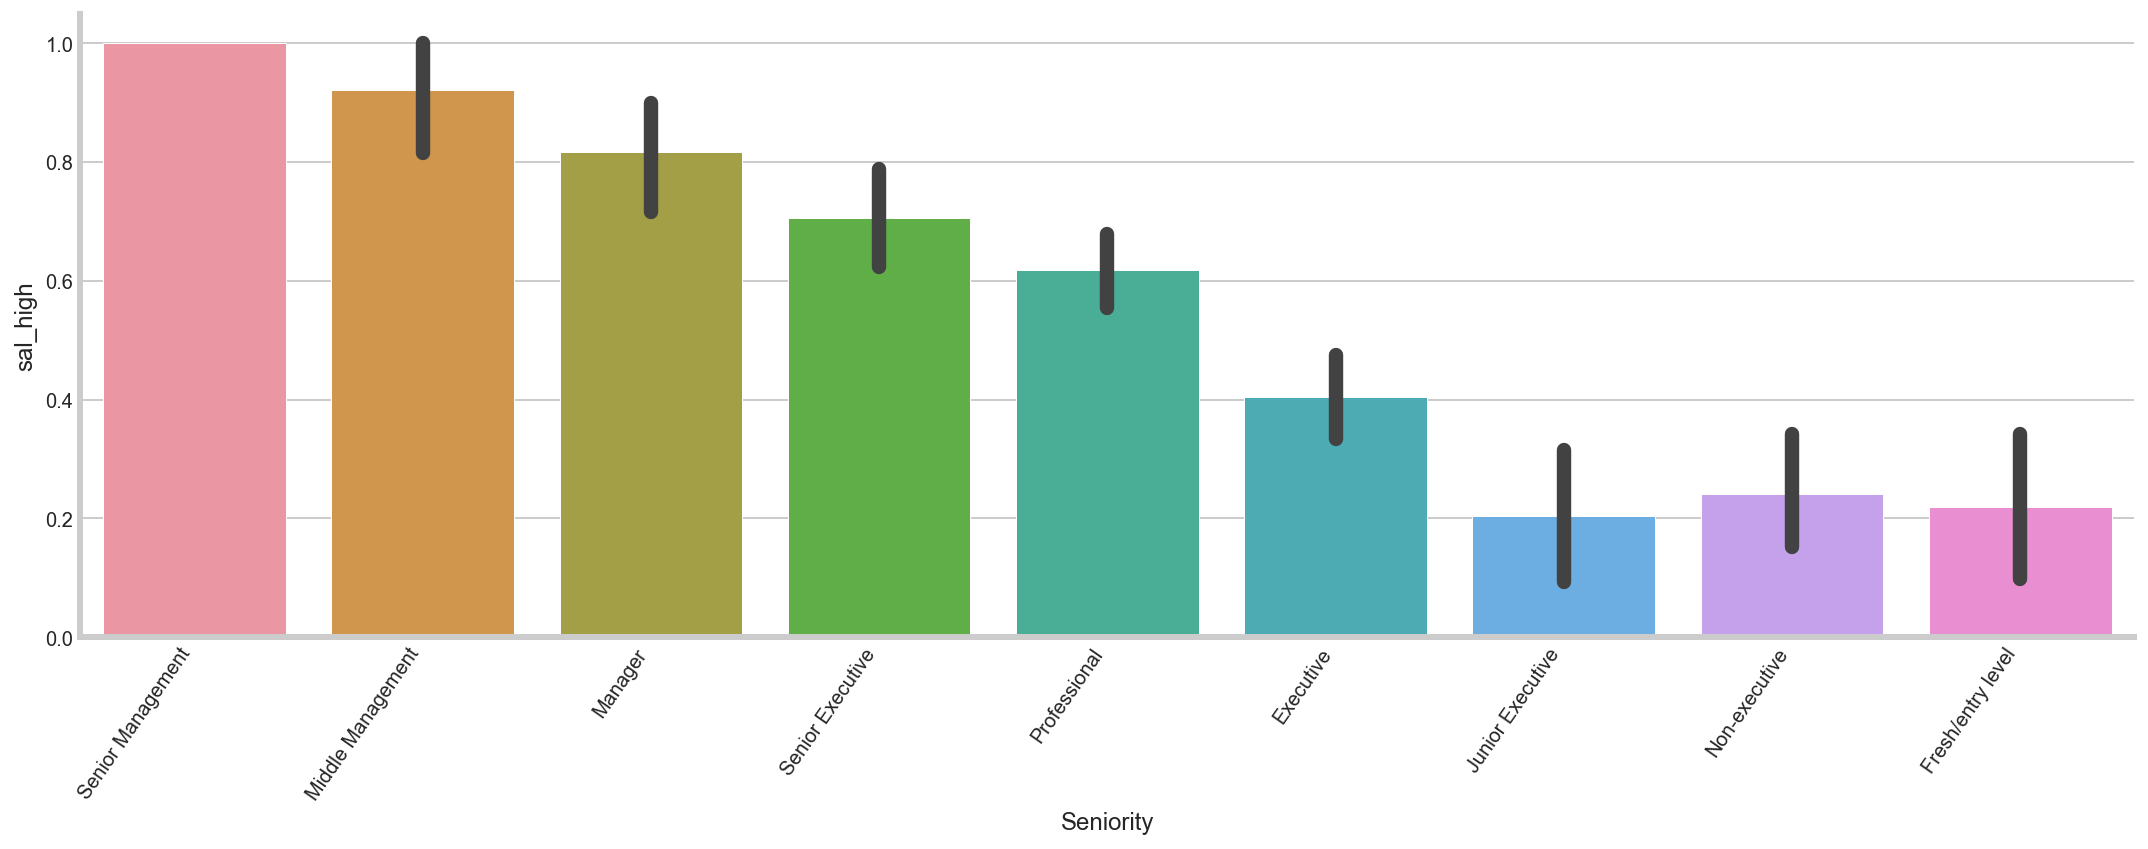

In [148]:
senior_order = ('Senior Management', 'Middle Management', 'Manager','Senior Executive',
                'Professional','Executive', 'Junior Executive','Non-executive','Fresh/entry level')

sns.catplot(x='Seniority', y='sal_high',data=job_df, kind='bar', aspect=3, 
               order=senior_order).set_xticklabels(rotation=55, horizontalalignment='right')
plt.show();

In [149]:
seniority_cat=job_df['Seniority'].str.get_dummies()
seniority_cat.head()

,Executive,Fresh/entry level,Junior Executive,Manager,Middle Management,Non-executive,Professional,Senior Executive,Senior Management
0,1,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0


In [150]:
job_df = pd.concat([job_df, seniority_cat], axis=1)

# Modeling
QUESTION 1: Factors that impact salary

In [151]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from nltk.corpus import stopwords

In [152]:
stop = stopwords.words('english')
stop += ['regret','shortlisted', 'candidates','notified','etc', 'take', 'hands']
#stop += ['regret', 'shortlisted', 'candidates', 'notified','least','skills',
#         'related','good','years','added','able','advantage','work','etc',
#         'working','ability','excellent','year','knowledge']

In [153]:
def get_freq_words(sparse_counts, columns):

    word_counts = np.asarray(X_all.sum(axis=0)).reshape(-1)
    # argsort() returns smallest first, so we reverse the result
    largest_count_indices = word_counts.argsort()[::-1]
    freq_words = pd.Series(word_counts[largest_count_indices], 
                           index=columns[largest_count_indices])

    return freq_words

In [154]:
#most common words for requirements
cvt      =  CountVectorizer(lowercase=True, strip_accents='unicode',
                       max_features=1500, min_df=5, max_df=0.7,
                       stop_words=stop, ngram_range=(1,2))
X_all    =  cvt.fit_transform(job_df['Requirements'])
columns  =  np.array(cvt.get_feature_names()) 

freq_words = get_freq_words(X_all, columns)
freq_words_percent = freq_words/len(job_df['Requirements'])
freq_words[:20]

data             1637
skills           1268
knowledge         719
ability           692
strong            681
years             593
work              567
business          522
management        511
working           496
good              486
degree            477
science           442
computer          422
communication     417
team              410
excellent         364
sql               328
related           318
learning          317
dtype: int64

In [155]:
#most common ngrams for requirements
cvt = CountVectorizer(lowercase=True, strip_accents='unicode',
                       max_features=1500, min_df=5, max_df=0.7,
                       stop_words=stop, ngram_range=(2,2))
X_all = cvt.fit_transform(job_df['Requirements'])
columns  =  np.array(cvt.get_feature_names())

freq_words = get_freq_words(X_all, columns)
freq_words[:10]

computer science        291
communication skills    267
years experience        224
machine learning        201
problem solving         168
ability work            157
big data                149
experience working      143
skills ability          142
team player             130
dtype: int64

In [156]:
tfid = TfidfVectorizer(lowercase=True, strip_accents='unicode',
                       max_features=1500, min_df=5, max_df=0.7,
                       stop_words=stop, ngram_range=(2,2))
X_all = tfid.fit_transform(job_df['Requirements'])
columns  =  np.array(tfid.get_feature_names())

freq_words = get_freq_words(X_all, columns)
freq_words[:10]

communication skills    25.591916
computer science        25.538059
years experience        22.934461
machine learning        21.423508
least years             17.625518
problem solving         17.451751
ability work            17.350427
experience working      16.833215
team player             16.443906
big data                15.745155
dtype: float64

In [157]:
#CountVectorizer job requirements columns
cvec = CountVectorizer(lowercase=True, strip_accents='unicode',
                       max_features=1500, min_df=5, max_df=0.7, 
                       stop_words=stop,ngram_range=(1,2))
cvec.fit(job_df['Requirements'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=1500, min_df=5,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...t", 'wouldn', "wouldn't", 'regret', 'shortlisted', 'candidates', 'notified', 'etc', 'take', 'hands'],
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [158]:
model_data = job_df.drop(columns=['Job_Title','Company','Seniority','Category','sal_min','sal_max','Avg Salary'])

In [159]:
nlp = pd.DataFrame(cvec.transform(model_data['Requirements']).todense(),
                       columns=cvec.get_feature_names())

In [160]:
senior_nlp = pd.concat([model_data, nlp], axis=1)
senior_nlp.shape

(838, 1511)

In [161]:
X = senior_nlp.drop(columns=['sal_high','Requirements'])
X_nlp = nlp
y = senior_nlp['sal_high'].values

In [162]:
#Data with dummified 'seniority' and countvectorized 'requirements'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [163]:
#Data with countvectorized 'requirements' only
X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(X_nlp, y, test_size=0.2, random_state=42)

#### Choosing best model (Logistic, AdaBoost, RandomForest)

In [164]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('Cross val score on train NLP+Seniority dummy data:', np.mean(cross_val_score(lr, X_train, y_train, cv=5)))
print('Cross val score on train NLP data:', np.mean(cross_val_score(lr, X_train_nlp, y_train_nlp, cv=5)))

Cross val score on train NLP+Seniority dummy data: 0.7268761455878503
Cross val score on train NLP data: 0.7045092000315881


In [165]:
from sklearn.ensemble import AdaBoostClassifier
Ada = AdaBoostClassifier()
Ada.fit(X_train, y_train)
print('Cross val score on train NLP+Seniority dummy data:', np.mean(cross_val_score(Ada, X_train, y_train, cv=5)))
print('Cross val score on train NLP data:', np.mean(cross_val_score(Ada, X_train_nlp, y_train_nlp, cv=5)))

Cross val score on train NLP+Seniority dummy data: 0.722409423226391
Cross val score on train NLP data: 0.688335515405429


In [166]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)
print('Cross val score on train NLP+Seniority dummy data:', np.mean(cross_val_score(rfc, X_train, y_train, cv=5)))
print('Cross val score on train NLP data:', np.mean(cross_val_score(rfc, X_train_nlp, y_train_nlp, cv=5)))

Cross val score on train NLP+Seniority dummy data: 0.682231033637161
Cross val score on train NLP data: 0.6629164952181449


1) Data consists of dummified seniority and CountVectorized requirements provide better cross val score across all models

2) Logistic regression model having best cross val score compare to ensemble models (AdaBoost and RandomForest)

### Logistic regression model with hyperparameter tune and classfication report

In [167]:
#hyperparameter tune for logistic regression
lr_params = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
gs_lr = GridSearchCV(lr, param_grid=lr_params, cv=5, scoring='roc_auc', n_jobs=-1)
gs_lr.fit(X_train,y_train)

lr_c2=gs_lr.best_estimator_
lr_c2.fit(X_train,y_train)

print('Cross val score on train data:', np.mean(cross_val_score(lr_c2, X_train, y_train, cv=5)))
print('AUC score on test data:',roc_auc_score(y_test,lr_c2.predict_proba(X_test)[:,1]))

Cross val score on train data: 0.7150242937359984
AUC score on test data: 0.8222222222222223


In [168]:
pd.DataFrame(confusion_matrix(y_test,lr_c2.predict(X_test)),
             index=['Actual Low Salary','Actual High Salary'],
             columns=['Predicted Low Salary','Predicted High Salary'])

,Predicted Low Salary,Predicted High Salary
Actual Low Salary,52,23
Actual High Salary,24,69


In [169]:
print(classification_report(y_test,lr_c2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.69      0.69        75
           1       0.75      0.74      0.75        93

   micro avg       0.72      0.72      0.72       168
   macro avg       0.72      0.72      0.72       168
weighted avg       0.72      0.72      0.72       168



In [170]:
features = np.array(X_train.columns)
lr_coefs = pd.DataFrame({'coef':lr_c2.coef_[0], 'abs coef':abs(lr_c2.coef_[0])},index=features)
lr_coefs = lr_coefs.sort_values('abs coef',ascending=False)
lr_coefs.head(10)

,coef,abs coef
phd,0.436951,0.436951
diploma,-0.432527,0.432527
Executive,-0.420766,0.420766
Junior Executive,-0.388593,0.388593
sciences,-0.382525,0.382525
Non-executive,-0.373823,0.373823
Fresh/entry level,-0.373046,0.373046
statistical,-0.350504,0.350504
engineering,-0.350026,0.350026
work experience,0.333218,0.333218


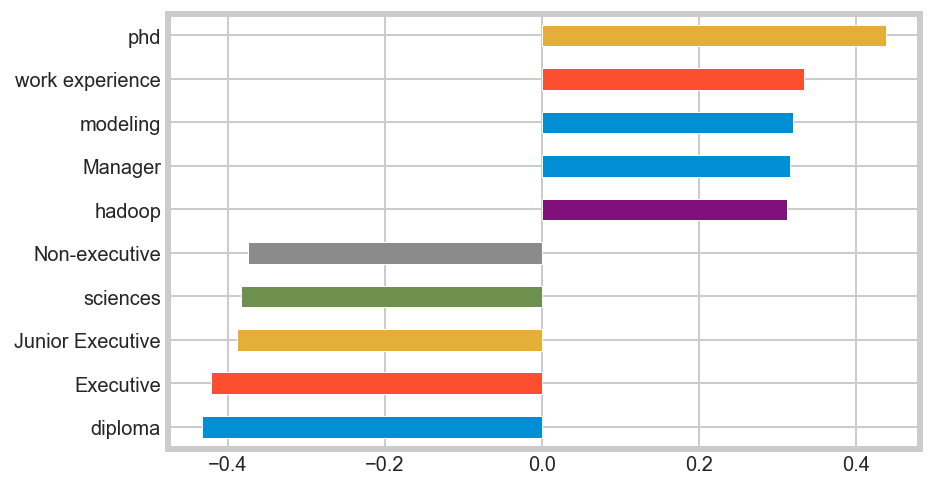

In [171]:
imp_coefs = pd.concat([lr_coefs.sort_values('coef',ascending = True).head(5),
                     lr_coefs.sort_values('coef',ascending = True).tail(5)])
imp_coefs['coef'].plot(kind = "barh")

### Random Forest model with hyperparameter tune and classfication report

In [172]:
rfc_params={
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'n_estimators': [50,100,150,200]}

gs_rfc=GridSearchCV(rfc, rfc_params, cv=5, scoring='roc_auc', n_jobs=-1)
gs_rfc.fit(X_train,y_train)

rfc2=gs_rfc.best_estimator_
rfc2.fit(X_train,y_train)

print('Cross val score on train data:', np.mean(cross_val_score(lr_c2, X_train, y_train, cv=5)))
print('AUC score on test data:',roc_auc_score(y_test,lr_c2.predict_proba(X_test)[:,1]))

Cross val score on train data: 0.7150242937359984
AUC score on test data: 0.8222222222222223


In [173]:
pd.DataFrame(confusion_matrix(y_test,rfc2.predict(X_test)),
             index=['Actual Low Salary','Actual High Salary'],
             columns=['Predicted Low Salary','Predicted High Salary'])

,Predicted Low Salary,Predicted High Salary
Actual Low Salary,57,18
Actual High Salary,20,73


In [174]:
print(classification_report(y_test,rfc2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75        75
           1       0.80      0.78      0.79        93

   micro avg       0.77      0.77      0.77       168
   macro avg       0.77      0.77      0.77       168
weighted avg       0.77      0.77      0.77       168



In [175]:
features = np.array(X_train.columns)
rf_coefs = pd.DataFrame({'coef':rfc2.feature_importances_},index=features)
rf_coefs.sort_values('coef',ascending = False).head(10)

,coef
diploma,0.019053
Executive,0.010172
hadoop,0.009967
data,0.009954
technical,0.006599
Junior Executive,0.006565
salary,0.006396
modeling,0.006352
Senior Management,0.005862
sciences,0.005800


### AdaBoost model with hyperparameter tune and classfication report

In [176]:
ada_params = {'n_estimators' : [50,100,150,200,250,500],'learning_rate' : [.5,.75,1.0,1.25,1.5,1.75,2.0]}
gs_ada = GridSearchCV(Ada, param_grid=ada_params, cv=5, scoring='roc_auc', n_jobs=-1)
gs_ada.fit(X_train,y_train)

ada_c2=gs_ada.best_estimator_
ada_c2.fit(X_train,y_train)

print('Cross val score on train data:', np.mean(cross_val_score(ada_c2, X_train, y_train, cv=5)))
print('AUC score on test data:',roc_auc_score(y_test,ada_c2.predict_proba(X_test)[:,1]))

Cross val score on train data: 0.747738999239392
AUC score on test data: 0.8199283154121864


In [177]:
pd.DataFrame(confusion_matrix(y_test,ada_c2.predict(X_test)),
             index=['Actual Low Salary','Actual High Salary'],
             columns=['Predicted Low Salary','Predicted High Salary'])

,Predicted Low Salary,Predicted High Salary
Actual Low Salary,58,17
Actual High Salary,22,71


In [178]:
print(classification_report(y_test,ada_c2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.72      0.77      0.75        75
           1       0.81      0.76      0.78        93

   micro avg       0.77      0.77      0.77       168
   macro avg       0.77      0.77      0.77       168
weighted avg       0.77      0.77      0.77       168



In [179]:
features = np.array(X_train.columns)
ada_coefs = pd.DataFrame({'coef':ada_c2.feature_importances_},index=features)
ada_coefs.sort_values('coef',ascending = False).head(10)

,coef
Non-executive,0.020
Middle Management,0.018
Professional,0.016
phd,0.014
sciences,0.012
command,0.012
projects,0.012
minimum bachelor,0.010
integration,0.010
Fresh/entry level,0.010


In [180]:
#Top 10 features for salary high and low prediction.
Ada_feat = ada_coefs.sort_values('coef',ascending = False).head(10).index
Logit_reg = lr_coefs.sort_values('abs coef',ascending=False).head(10).index
rf_feat = rf_coefs.sort_values('coef',ascending = False).head(10).index

sal_features = pd.DataFrame({'AdaBoost model':Ada_feat, 'Logistic model':Logit_reg, 'Random Forest':rf_feat})
sal_features

,AdaBoost model,Logistic model,Random Forest
0,Non-executive,phd,diploma
1,Middle Management,diploma,Executive
2,Professional,Executive,hadoop
3,phd,Junior Executive,data
4,sciences,sciences,technical
5,command,Non-executive,Junior Executive
6,projects,Fresh/entry level,salary
7,minimum bachelor,statistical,modeling
8,integration,engineering,Senior Management
9,Fresh/entry level,work experience,sciences


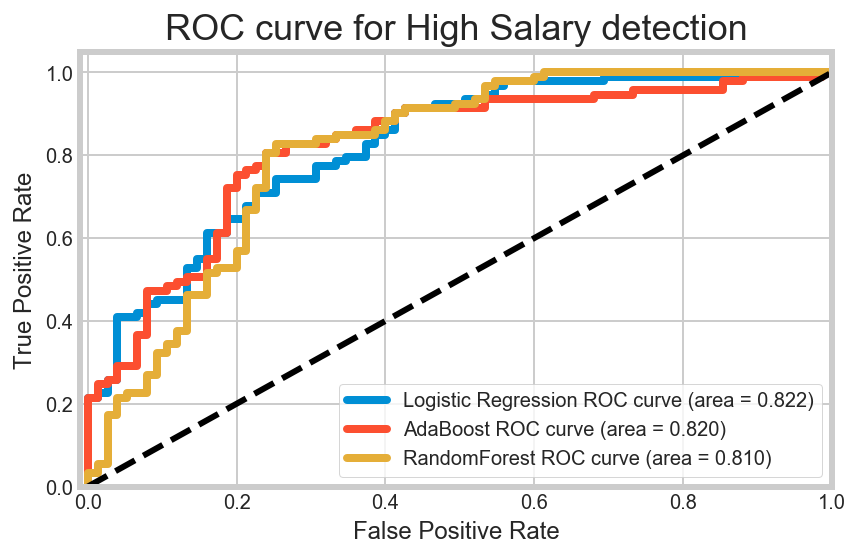

In [181]:
#ROC curve for all 3 models

y_score_lr = lr_c2.predict_proba(X_test)[:,1]
y_score_ada = ada_c2.predict_proba(X_test)[:,1]
y_score_rf = rfc2.predict_proba(X_test)[:,1]

FPR1, TPR1, THR1 = roc_curve(y_test,y_score_lr)
FPR2, TPR2, THR2 = roc_curve(y_test,y_score_ada)
FPR3, TPR3, THR3 = roc_curve(y_test,y_score_rf)
ROC_AUC1=auc(FPR1,TPR1)
ROC_AUC2=auc(FPR2,TPR2)
ROC_AUC3=auc(FPR3,TPR3)

plt.plot(FPR1, TPR1, label='Logistic Regression ROC curve (area = %0.3f)' % ROC_AUC1, linewidth=4)
plt.plot(FPR2, TPR2, label='AdaBoost ROC curve (area = %0.3f)' % ROC_AUC2, linewidth=4)
plt.plot(FPR3, TPR3, label='RandomForest ROC curve (area = %0.3f)' % ROC_AUC3, linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve for High Salary detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

1) In conclusion, all 3 models (logisitic regression, Adaboost and RandomForest) AUC score are above 0.8 with recall and precision rate above 0.7. Logistic regression was choosen as the best model for higher AUC score.

2) Top 5 job requirements which have positive coefficient for higher salary are PhD holder, manager level, modeling skill, knowledge in using hadoop and work experience.

3) Top 5 job requirements which have negative coefficient on the salary are diploma holder, fresh/entry level, executive level, junior executive level and non-executive. 

4) We can conclude that seniority below or above manager level is one of the main factor for salary above or below median. Other than seniority, education level and specific skills also contribute certain weightage on salary

### Question 2:
Identify features in the data related to job postings that can distinguish job titles from each other. 
What components of a job posting distinguish data scientists from other data jobs?

In [182]:
job_title = job_clean[['Job_Title','Requirements']]

In [183]:
#job titles containing keywords below are considered as data scientists role
title_key = ['SCIENCE','SCIENCTIST','MACHINE','DEEP','NLP','ANALYST','ANALYTIC']
key = '|'.join(title_key)

In [184]:
#1 for data science role, 0 for others
job_title["data_science"] = np.where(job_title['Job_Title'].str.upper().str.contains(key), 1, 0)

In [185]:
job_title.head()

,Job_Title,Requirements,data_science
0,"Data Engineer (5 days, Orchard, $3500-4000)","Minimum Degree/Diploma in Computer Science, ...",0
1,Customer Engagement Excellence Learning Manager,A University / Bachelors degree holder in app...,0
2,"Manager, Research","·A smart communicator, a team player with proa...",0
3,"Head of Research & Evaluation, Asia",Qualifications 10 plus years expertise and do...,0
4,IT Systems Adminstrator,""" Bachelors Degree in Computer Science, Comput...",0


In [186]:
job_title['data_science'].value_counts()

0    3473
1     458
Name: data_science, dtype: int64

In [187]:
#baseline to predict data science job is 0.11, which indicate this is a imbalance data
job_title[job_title['data_science']==1].count().Job_Title/len(job_title['data_science'])

0.11650979394556092

In [188]:
#using hashingvectorizer to enhance stopword
from sklearn.feature_extraction.text import HashingVectorizer
hashvect      =  HashingVectorizer(lowercase=True, strip_accents='unicode',
                 stop_words=stop, ngram_range=(2,3))

DS_hash    =  hashvect.fit_transform(ds['Requirements'])
hash_stop = list(hashvect.get_stop_words())

In [287]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from nltk.corpus import stopwords

#CountVectorizer job requirements columns
stop = stopwords.words('english')
stop += ['regret','shortlisted', 'candidates','notified','etc', 'take', 'hands',
         'related','least','able','good','preferred','skill','experience','degree',
         'hours', 'work', 'gce']
stop += hash_stop

cvec = CountVectorizer(lowercase=True, strip_accents='unicode',
                       max_features=1500, min_df=5, max_df=0.4, 
                       stop_words=stop,ngram_range=(2,3))
cvec.fit(job_title['Requirements'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=1500, min_df=5,
        ngram_range=(2, 3), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...'wouldn', 'she', 'i', 'between', 'more', 'd', 'hadn', 'all', 'me', 'myself', 'who', 'until', 'have'],
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [288]:
nlp = pd.DataFrame(cvec.transform(job_title['Requirements']).todense(),
                       columns=cvec.get_feature_names())

In [289]:
X = nlp
y = job_title['data_science'].values

In [290]:
#Data with dummified 'seniority' and countvectorized 'requirements'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [311]:
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight
#class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict({0:1.,1:15.})

from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

lr = LogisticRegression()
lr.fit(X_train, y_train)
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
rfc = RandomForestClassifier(class_weight=class_weights,random_state=42)
rfc.fit(X_train, y_train)

print('Logistic reg auc score:', np.mean(cross_val_score(lr, X_train, y_train, cv=5, scoring ='roc_auc')))
print('Logistic reg f1 score:', np.mean(cross_val_score(lr, X_train, y_train, cv=5, scoring ='f1')))
print('RandomForest auc score:', np.mean(cross_val_score(rfc, X_train, y_train, cv=5, scoring ='roc_auc')))
print('RandomForest f1 score:', np.mean(cross_val_score(rfc, X_train, y_train, cv=5, scoring ='f1')))

Logistic reg auc score: 0.7694925236638263
Logistic reg f1 score: 0.3691408532182653
RandomForest auc score: 0.7357866027202513
RandomForest f1 score: 0.30149806579713123


### Proceed with hyperparameter for logistic regression and random forest model
Using f1 score for gridsearch and scoring instean of auc score due to imbalance data on DS class

In [296]:
#hyperparameter tune for logistic regression (gridsearch based on f1 score)
lr_params = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
gs_lrf = GridSearchCV(lr, param_grid=lr_params, cv=5, scoring='f1', n_jobs=-1)
gs_lrf.fit(X_train,y_train)

lr_c2f=gs_lrf.best_estimator_
lr_c2f.fit(X_train,y_train)

print('Cross val f1 score on train data:', np.mean(cross_val_score(lr_c2f, X_train, y_train, cv=5, scoring='f1')))

Cross val f1 score on train data: 0.409071757621145
AUC score on test data: 0.710586974395114


In [297]:
features = np.array(X_train.columns)
lrf_coefs = pd.DataFrame({'coef':lr_c2f.coef_[0]},index=features)
lrf_coefs = lr_coefs.sort_values('coef',ascending=False)
lrf_coefs.head(10)

,coef
computer science,0.579959
mathematics statistics,0.541232
excel skills,0.520678
business analysis,0.476059
data analytics,0.470142
java python,0.464895
data mining,0.452639
detail oriented,0.448192
languages python,0.430797
business analyst,0.427701


In [298]:
pd.DataFrame(confusion_matrix(y_test,lr_c2f.predict(X_test)),
             index=['Actual None DS job','Actual DS job'],
             columns=['Predicted None DS job','Predicted DS job'])

,Predicted None DS job,Predicted DS job
Actual None DS job,637,51
Actual DS job,63,36


In [299]:
print(classification_report(y_test,lr_c2f.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       688
           1       0.41      0.36      0.39        99

   micro avg       0.86      0.86      0.86       787
   macro avg       0.66      0.64      0.65       787
weighted avg       0.85      0.86      0.85       787



In [300]:
#hyperparameter tune for random forest
rfc_params={
             'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'n_estimators': [50,100,150,200],
           }

gs_rfc=GridSearchCV(rfc, rfc_params, cv=5, scoring='f1', n_jobs=-1)
gs_rfc.fit(X_train,y_train)

rfc2=gs_rfc.best_estimator_
rfc2.fit(X_train,y_train)

print('Cross val f1 score on train data:', np.mean(cross_val_score(rfc2, X_train, y_train, cv=5, scoring='f1')))
print('AUC score on test data:',roc_auc_score(y_test,rfc2.predict_proba(X_test)[:,1]))

Cross val f1 score on train data: 0.3729207790580208
AUC score on test data: 0.7503964059196617


In [301]:
pd.DataFrame(confusion_matrix(y_test,rfc2.predict(X_test)),
             index=['Actual None DS job','Actual DS job'],
             columns=['Predicted None DS job','Predicted DS job'])

,Predicted None DS job,Predicted DS job
Actual None DS job,659,29
Actual DS job,70,29


In [302]:
print(classification_report(y_test,rfc2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       688
           1       0.50      0.29      0.37        99

   micro avg       0.87      0.87      0.87       787
   macro avg       0.70      0.63      0.65       787
weighted avg       0.85      0.87      0.86       787



In [303]:
features = np.array(X_train.columns)
rf_coefs = pd.DataFrame({'coef':rfc2.feature_importances_},index=features)
rf_coefs.sort_values('coef',ascending = False).head(10)

,coef
computer science,0.022547
machine learning,0.011750
data mining,0.009979
strong analytical,0.009340
year working,0.008296
positive attitude,0.007700
skills ability,0.007582
data analysis,0.006713
communication skills,0.006359
analytical skills,0.006119


In [310]:
#Top 10 features for salary high and low prediction.
Logit_reg = lrf_coefs.sort_values('coef',ascending=False).head(10).index
rf_feat = rf_coefs.sort_values('coef',ascending = False).head(10).index

DS_features = pd.DataFrame({'Logistic model':Logit_reg, 'Random Forest':rf_feat})
DS_features

,Logistic model,Random Forest
0,computer science,computer science
1,mathematics statistics,machine learning
2,excel skills,data mining
3,business analysis,strong analytical
4,data analytics,year working
5,java python,positive attitude
6,data mining,skills ability
7,detail oriented,data analysis
8,languages python,communication skills
9,business analyst,analytical skills


From the logistic regression model coefficient and random forest important features, we can conclude that specific features distinguished data science job from other data related job, such as a computer science or statistics degree, machine learning skill, data mining skill, strong in analytical and python programming.

### Trying with different threshold value to increase f1 score (using Random Forest model)

In [304]:
#re-predict y based on threshold value given
def re_predict (y, threshold):
        if y > threshold:
            return 1
        else:
            return 0

In [312]:
pred_y = rfc2.predict_proba(X_test)
new_pred = []
for i in range(len(pred_y)):
    new_pred.append(re_predict(pred_y[i,1], 0.45))

In [313]:
pd.DataFrame(confusion_matrix(y_test,new_pred),
             index=['Actual None DS job','Actual DS job'],
             columns=['Predicted None DS job','Predicted DS job'])

,Predicted None DS job,Predicted DS job
Actual None DS job,646,42
Actual DS job,61,38


In [314]:
print(classification_report(y_test,new_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       688
           1       0.47      0.38      0.42        99

   micro avg       0.87      0.87      0.87       787
   macro avg       0.69      0.66      0.68       787
weighted avg       0.86      0.87      0.86       787



By tuning the thresold value from 0.5 to 0.45, we managed to increase the true positive for DS job but the down side is more non DS job will be predicted as DS job.